In [40]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from collections import Counter
from scipy import linalg
import re
from collections import defaultdict


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pallavisingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Important Functions


In [5]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [6]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

In [7]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [8]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C) : i] + data[(i + 1) : (i + C + 1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq / num_ctx_words
        yield x, y
        i += 1
        if i >= len(data) - C:
            print("i is being set to", C)
            i = C

In [9]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

In [10]:
def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    #
    #     words = nltk.word_tokenize(data)
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # return these correctly
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [11]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    ### START CODE HERE ###
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    ### END CODE HERE ###
    return np.dot(evecs.T, data.T).T

In [14]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [15]:
with open('./data/shakespeare.txt') as f:
    data = f.read()

### Data Preprocessing

In [17]:
# Removing special characters
data = re.sub(r'[,!?;-]','.',data)

# Tokenizing data
data = nltk.word_tokenize(data)

# Converting everything in lowercase and dropping non-alphabet tokens
data = [c.lower() for c in data if c.isalpha() or c == '.']

print(len(data))

60976


In [18]:
data[:10]

['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend']

In [27]:
# Computing the frequency distribution of words
fdist = nltk.FreqDist(word for word in data)

type(fdist)

nltk.probability.FreqDist

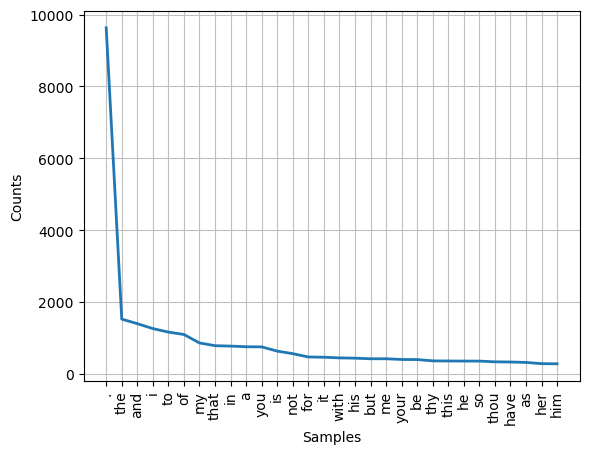

<Axes: xlabel='Samples', ylabel='Counts'>

In [28]:
fdist.plot(30, cumulative=False)


In [30]:
fdist

FreqDist({'.': 9630, 'the': 1521, 'and': 1394, 'i': 1257, 'to': 1159, 'of': 1093, 'my': 857, 'that': 781, 'in': 770, 'a': 752, ...})

Mapping words to indices and indices to words

In [31]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5775


## Training 

In [33]:
def initialize_model(N,V,random_seed = 1):
    W1 = np.random.rand(N,V)
    W2 = np.random.rand(V,N)
    b1 = np.random.rand(N,1)
    b2 = np.random.rand(V,1)
    
    return W1, W2, b1, b2

In [34]:
def softmax(z):
    yhat = np.exp(z)/np.sum(np.exp(z),axis=0)
    return yhat

### Forward Propagation

In [42]:
def forward_prop(x, W1, W2, b1, b2):
    
    h = np.dot(W1,x) + b1
    h = np.maximum(0,h)
    z = np.dot(W2,h) + b2
    
    return z, h

### Cost Function

In [46]:
# Implementing cross entropy cost function

def compute_cost(y,yhat,batch_size):
    
    logprob = np.multiply(np.log(yhat),y)
    cost = -1/batch_size * np.sum(logprob)
    cost = np.squeeze(cost)
    return cost

### Backpropagation

In [37]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    l1 = np.dot(W2.T,yhat-y)

    # Apply relu to l1
    l1[l1 < 0] = 0

    # compute the gradient for W1
    grad_W1 = 1/batch_size * np.dot(l1,x.T)

    # Compute gradient of W2
    grad_W2 = 1/batch_size * np.dot(yhat-y,h.T)
    
    # compute gradient for b1
    grad_b1 = 1/batch_size * np.dot(l1,np.ones((batch_size,1)))

    # compute gradient for b2
    grad_b2 = 1/batch_size * np.dot(yhat-y,np.ones((batch_size,1)))
    ### END CODE HERE ####
    
    return grad_W1, grad_W2, grad_b1, grad_b2

### Gradient Descent

In [48]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

    batch_size = 128
#    batch_size = 512
    iters = 0
    C = 2 
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        ### START CODE HERE (Replace instances of 'None' with your own code) ###                
        # get z and h
        z, h = forward_prop(x,W1,W2,b1,b2)
                
        # get yhat
        yhat = softmax(z)
        
        # get cost
        cost = compute_cost(y,yhat,batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
            
        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x,yhat,y,h,W1,W2,b1,b2,batch_size)
        
        # update weights and biases
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        ### END CODE HERE ###
        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2


In [49]:
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 10.661545
iters: 20 cost: 8.102256
iters: 30 cost: 11.391726
iters: 40 cost: 4.944900
iters: 50 cost: 9.679288
iters: 60 cost: 7.424884
iters: 70 cost: 6.681740
iters: 80 cost: 11.833590
iters: 90 cost: 9.649424
iters: 100 cost: 10.168823
iters: 110 cost: 4.242954
iters: 120 cost: 3.957345
iters: 130 cost: 7.363873
iters: 140 cost: 10.225562
iters: 150 cost: 3.257407


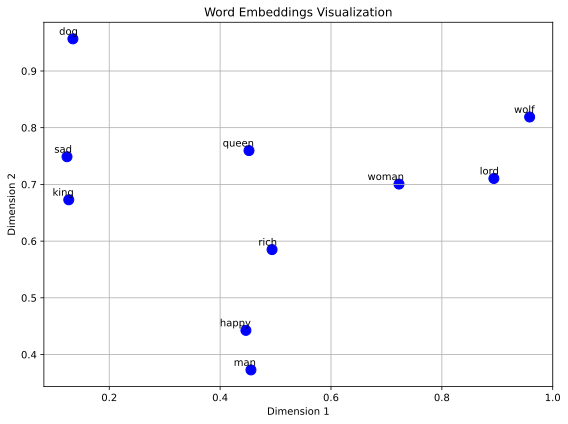

In [50]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'  # To make the plot high-resolution

# Example data
words = ['king', 'queen', 'lord', 'man', 'woman', 'dog', 'wolf', 'rich', 'happy', 'sad']

# Example embeddings (replace with your actual computation)
# Assuming X is your matrix of embeddings
# Replace this with your actual computation
# embs = (W1.T + W2) / 2.0  # Example computation

# Example word2Ind mapping (replace with your actual mapping)
word2Ind = {word: idx for idx, word in enumerate(words)}

# Example X matrix (replace with your actual embeddings)
# Assuming X is your matrix of embeddings
X = np.random.rand(len(words), 2)  # Example 2D embeddings

# Retrieve indices of words
idx = [word2Ind[word] for word in words]

# Extract embeddings for visualization
X_vis = X[idx, :]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], marker='o', color='b', s=100)

# Add annotations for each point
for i, word in enumerate(words):
    plt.annotate(word, xy=(X_vis[i, 0], X_vis[i, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.title('Word Embeddings Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()
